In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle
import numpy as np

In [78]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_data_X, Y_data, test_size=0.33, random_state=42)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating initial dataframe

y_train_df = pd.DataFrame(y_train, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_train_df['New'] = labelencoder.fit_transform(y_train_df['Label'])
y_test_df = pd.DataFrame(y_test, columns=['Label'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
y_test_df['New'] = labelencoder.fit_transform(y_test_df['Label'])

In [0]:
from keras import backend as K
img_rows, img_cols = X_train[0].shape


# transform data set
if K.common.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

**Parseval Network**

**Constrait**

In [83]:
from keras.models import Model
from keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.common.image_dim_ordering() == "th" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='Orthogonal',
                      W_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.common.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, W_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from keras.utils import plot_model
    from keras.layers import Input
    from keras.models import Model

    init = (68, 100,1)

    wrn_28_10 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.0)

    wrn_28_10.summary()

   # plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)


conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 68, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 68, 100, 16)  144         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 68, 100, 16)  64          conv2d_106[0][0]                 
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 68, 100, 16)  0           batch_normalization_85[0][0]     
__________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks as callbacks
import keras.utils.np_utils as kutils

In [0]:
EPOCHS = 200
BS = 128
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
horizontal_flip=True, fill_mode="nearest")

In [0]:
from keras.callbacks import LearningRateScheduler
import math
from keras.optimizers import SGD

sgd = SGD(lr=0.1, momentum=0.9)

In [87]:
wrn_28_10.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [0]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
def lr_sch(epoch):
    if epoch < 60:
        return 0.1
    elif epoch < 120:
        return 0.02
    elif epoch < 160:
        return 0.004
    else:
        return 0.0008

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [91]:
from keras.utils import to_categorical
hist = wrn_28_10.fit_generator(generator.flow(X_train, to_categorical(y_train_df['New']), batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   validation_data=(X_test, to_categorical(y_test_df['New'])), callbacks = [lr_scheduler],
                   validation_steps=X_test.shape[0] // BS,)

Epoch 1/200
29/29 [==============================] - 10s 353ms/step - loss: 1.8237 - acc: 0.3409 - val_loss: 1.8426 - val_acc: 0.3293
Epoch 2/200
29/29 [==============================] - 7s 258ms/step - loss: 1.7304 - acc: 0.4030 - val_loss: 1.6811 - val_acc: 0.4013
Epoch 3/200
29/29 [==============================] - 7s 258ms/step - loss: 1.6917 - acc: 0.4027 - val_loss: 1.6280 - val_acc: 0.4690
Epoch 4/200
29/29 [==============================] - 7s 259ms/step - loss: 1.6343 - acc: 0.4410 - val_loss: 1.5885 - val_acc: 0.4457
Epoch 5/200
29/29 [==============================] - 8s 259ms/step - loss: 1.5831 - acc: 0.4667 - val_loss: 1.5467 - val_acc: 0.4902
Epoch 6/200
29/29 [==============================] - 7s 258ms/step - loss: 1.4875 - acc: 0.5136 - val_loss: 1.4928 - val_acc: 0.5379
Epoch 7/200
29/29 [==============================] - 7s 258ms/step - loss: 1.4560 - acc: 0.5258 - val_loss: 2.0506 - val_acc: 0.4023
Epoch 8/200
29/29 [==============================] - 7s 259ms/step -

In [0]:
from keras.utils import to_categorical


# Fit the model
hist = wrn_28_10.fit(X_train, to_categorical(y_train_df['New']), validation_data=(X_test,to_categorical(y_test_df['New'])), epochs=EPOCHS, batch_size=BS, verbose=2)

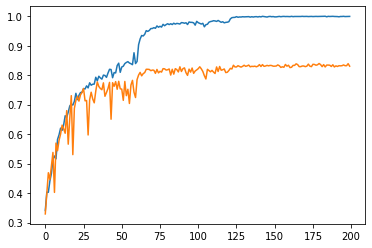

In [118]:
from matplotlib import  pyplot


pyplot.plot(hist.history["acc"], label='train')
pyplot.plot(hist.history['val_acc'], label='test')
pyplot.savefig("deneme.png")

In [0]:
test_err = [1.0-x for x in hist.history['val_acc']]

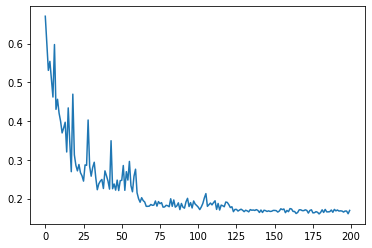

In [117]:
pyplot.plot(test_err, label='test')
pyplot.savefig("deneme_err.png")

In [0]:
import tensorflow as tf
wrn_28_10.save("_lst.h5")

In [0]:
y_pred = wrn_28_10.predict(X_test)

In [105]:
y_pred[8]

array([5.8299833e-04, 9.9938881e-01, 2.6950407e-05, 1.1227185e-06],
      dtype=float32)

In [104]:
np.argmax(y_pred[8])

1

In [111]:
wrn_28_10.evaluate(X_test,to_categorical(y_test_df['New']),batch_size=128,verbose=2)

[0.921227546644438, 0.8305981755256653]